In [1]:
import pandas as pd

In [2]:
import torch
torch.cuda.is_available()

True

In [2]:
import scanpy as sc

In [4]:
sc.settings.verbosity = 3  
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-06-09 00:04:19.332272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 00:04:20.766225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
import scvi

In [5]:
adata_3 = sc.read_10x_h5(
    "/home/mmigl/cellbender/output/sample3_filtered_filtered.h5"
)

In [6]:
adata_3

AnnData object with n_obs × n_vars = 4411 × 37143
    var: 'gene_ids', 'feature_types', 'genome'

In [161]:
#Pre-processing for improving the quality of the data before analysis

In [7]:
adata_3.var_names_make_unique()
sc.pp.filter_cells(adata_3, min_genes=200) 
sc.pp.filter_genes(adata_3, min_cells=3) 

In [8]:
adata_3

AnnData object with n_obs × n_vars = 3716 × 18054
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [190]:
#Doublet Removal

In [23]:
#pip install --user scikit-misc

In [9]:
doublet_3 = adata_3.copy()

In [10]:
sc.pp.highly_variable_genes(doublet_3, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [11]:
scvi.model.SCVI.setup_anndata(doublet_3)
vae = scvi.model.SCVI(doublet_3)
vae.train()

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8700
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████| 400/400 [01:30<00:00,  4.42it/s, v_num=1, train_loss_step=471, train_loss_epoch=476]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████| 400/400 [01:30<00:00,  4.43it/s, v_num=1, train_loss_step=471, train_loss_epoch=476]


In [12]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 247/400:  62%|██████████▍      | 247/400 [00:56<00:34,  4.38it/s, v_num=1, train_loss_step=0.362, train_loss_epoch=0.44]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.455. Signaling Trainer to stop.


In [13]:
doublet = solo.predict()
doublet['prediction'] = solo.predict(soft = False)

In [14]:
doublet.groupby('prediction').count()

doublet  singlet
prediction                  
doublet        1561     1561
singlet        2155     2155

In [15]:
doublet['difference'] = doublet.doublet - doublet.singlet

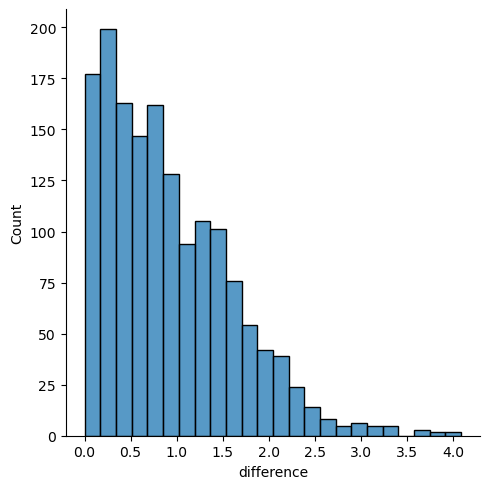

In [16]:
import seaborn as sns
sns.displot(doublet[doublet.prediction == 'doublet'], x = 'difference')

In [17]:
doublet = doublet[(doublet['prediction'] == 'doublet') & (doublet['difference'] > 1)]

In [18]:
adata_3.obs['doublet'] = adata_3.obs.index.isin(doublet.index)

In [19]:
adata_3 = adata_3[~adata_3.obs.doublet]

In [20]:
adata_3

View of AnnData object with n_obs × n_vars = 3117 × 18054
    obs: 'n_genes', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [21]:
adata_3.var["mt"] = adata_3.var_names.str.startswith("MT-")

In [22]:
sc.pp.calculate_qc_metrics(adata_3, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

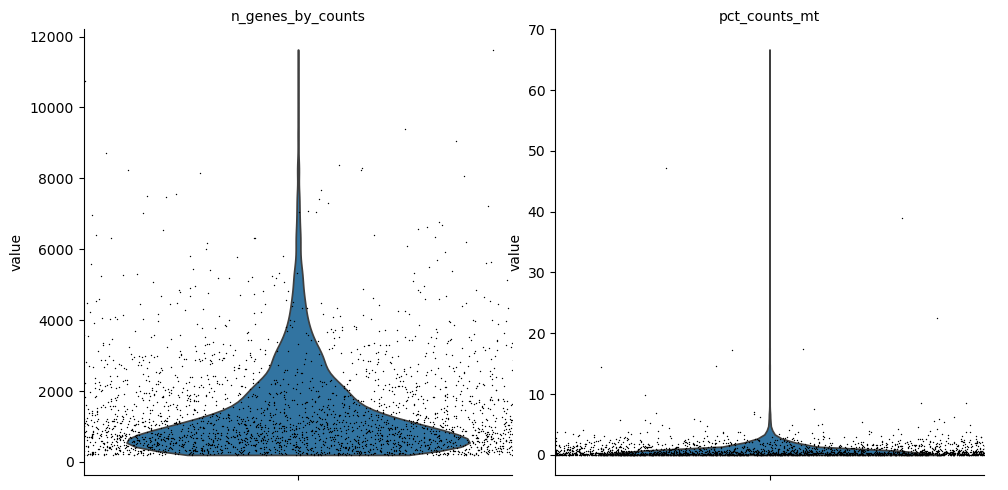

In [23]:
sc.pl.violin(adata_3, ['n_genes_by_counts', 'pct_counts_mt'], 
             jitter=0.6, multi_panel=True)

In [24]:
import numpy as np

In [25]:
def pp(adata):
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim)]
    adata = adata[adata.obs.pct_counts_mt < 5]
    sc.write('adata_3_filtered_new.h5ad', adata)
    adata.layers['Counts'] = adata.X.copy()
    sc.pp.normalize_total(adata) 
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True, layer = 'Counts', flavor = "seurat_v3")
    adata.raw = adata 
    adata = adata[:, adata.var.highly_variable] 
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) 
    sc.pp.scale(adata, max_value=10) 
    sc.tl.pca(adata, svd_solver='arpack')
    sc.write('adata_3_pca_new.h5ad', adata)
    return adata

In [26]:
adata_3 = pp(adata_3)

In [27]:
adata_3

AnnData object with n_obs × n_vars = 3023 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Counts'

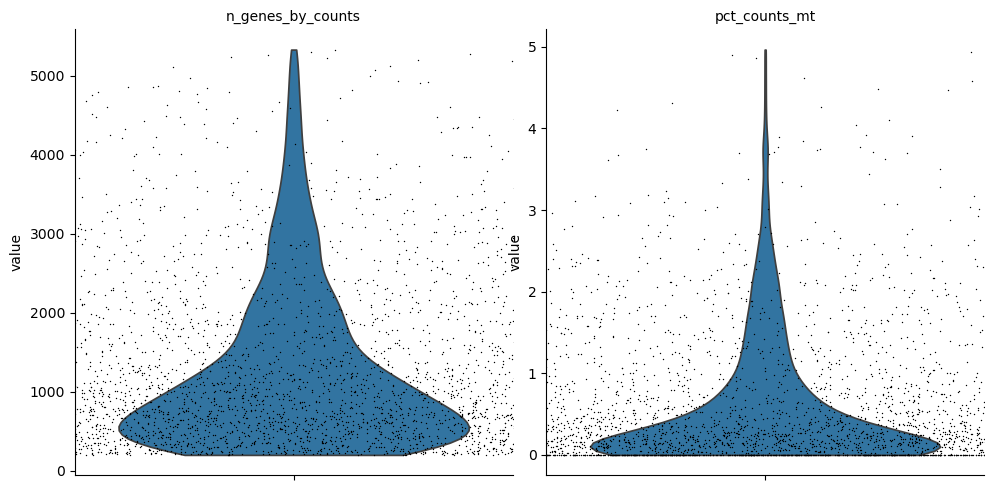

In [28]:
sc.pl.violin(adata_3, ['n_genes_by_counts', 'pct_counts_mt'], 
             jitter=0.6, multi_panel=True)

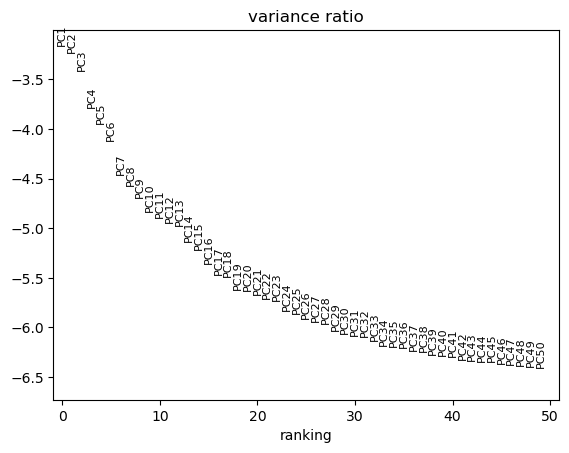

In [29]:
sc.pl.pca_variance_ratio(adata_3, log=True, n_pcs=50)

In [31]:
sc.pp.neighbors(adata_3, n_pcs=41)
sc.tl.leiden(adata_3, resolution = 0.5)
sc.tl.umap(adata_3)
sc.tl.rank_genes_groups(adata_3, "leiden", method="wilcoxon")
sc.write('adata_3_de_new.h5ad', adata_3)

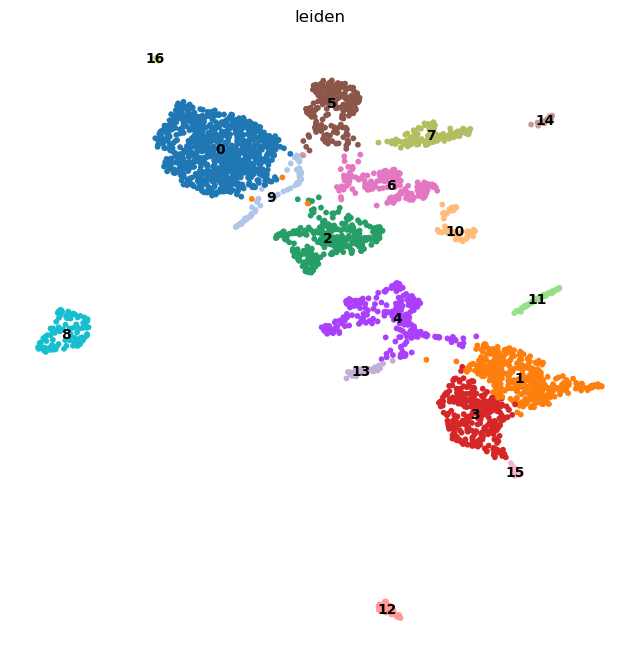

In [33]:
from matplotlib import rc_context
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_3, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

In [37]:
n_markers = ['S100A12', 'SPP1', 'VEGFA', 'CXCL8', 'IL1B', 'IFIT1', 'ISG15', 'MMP9']

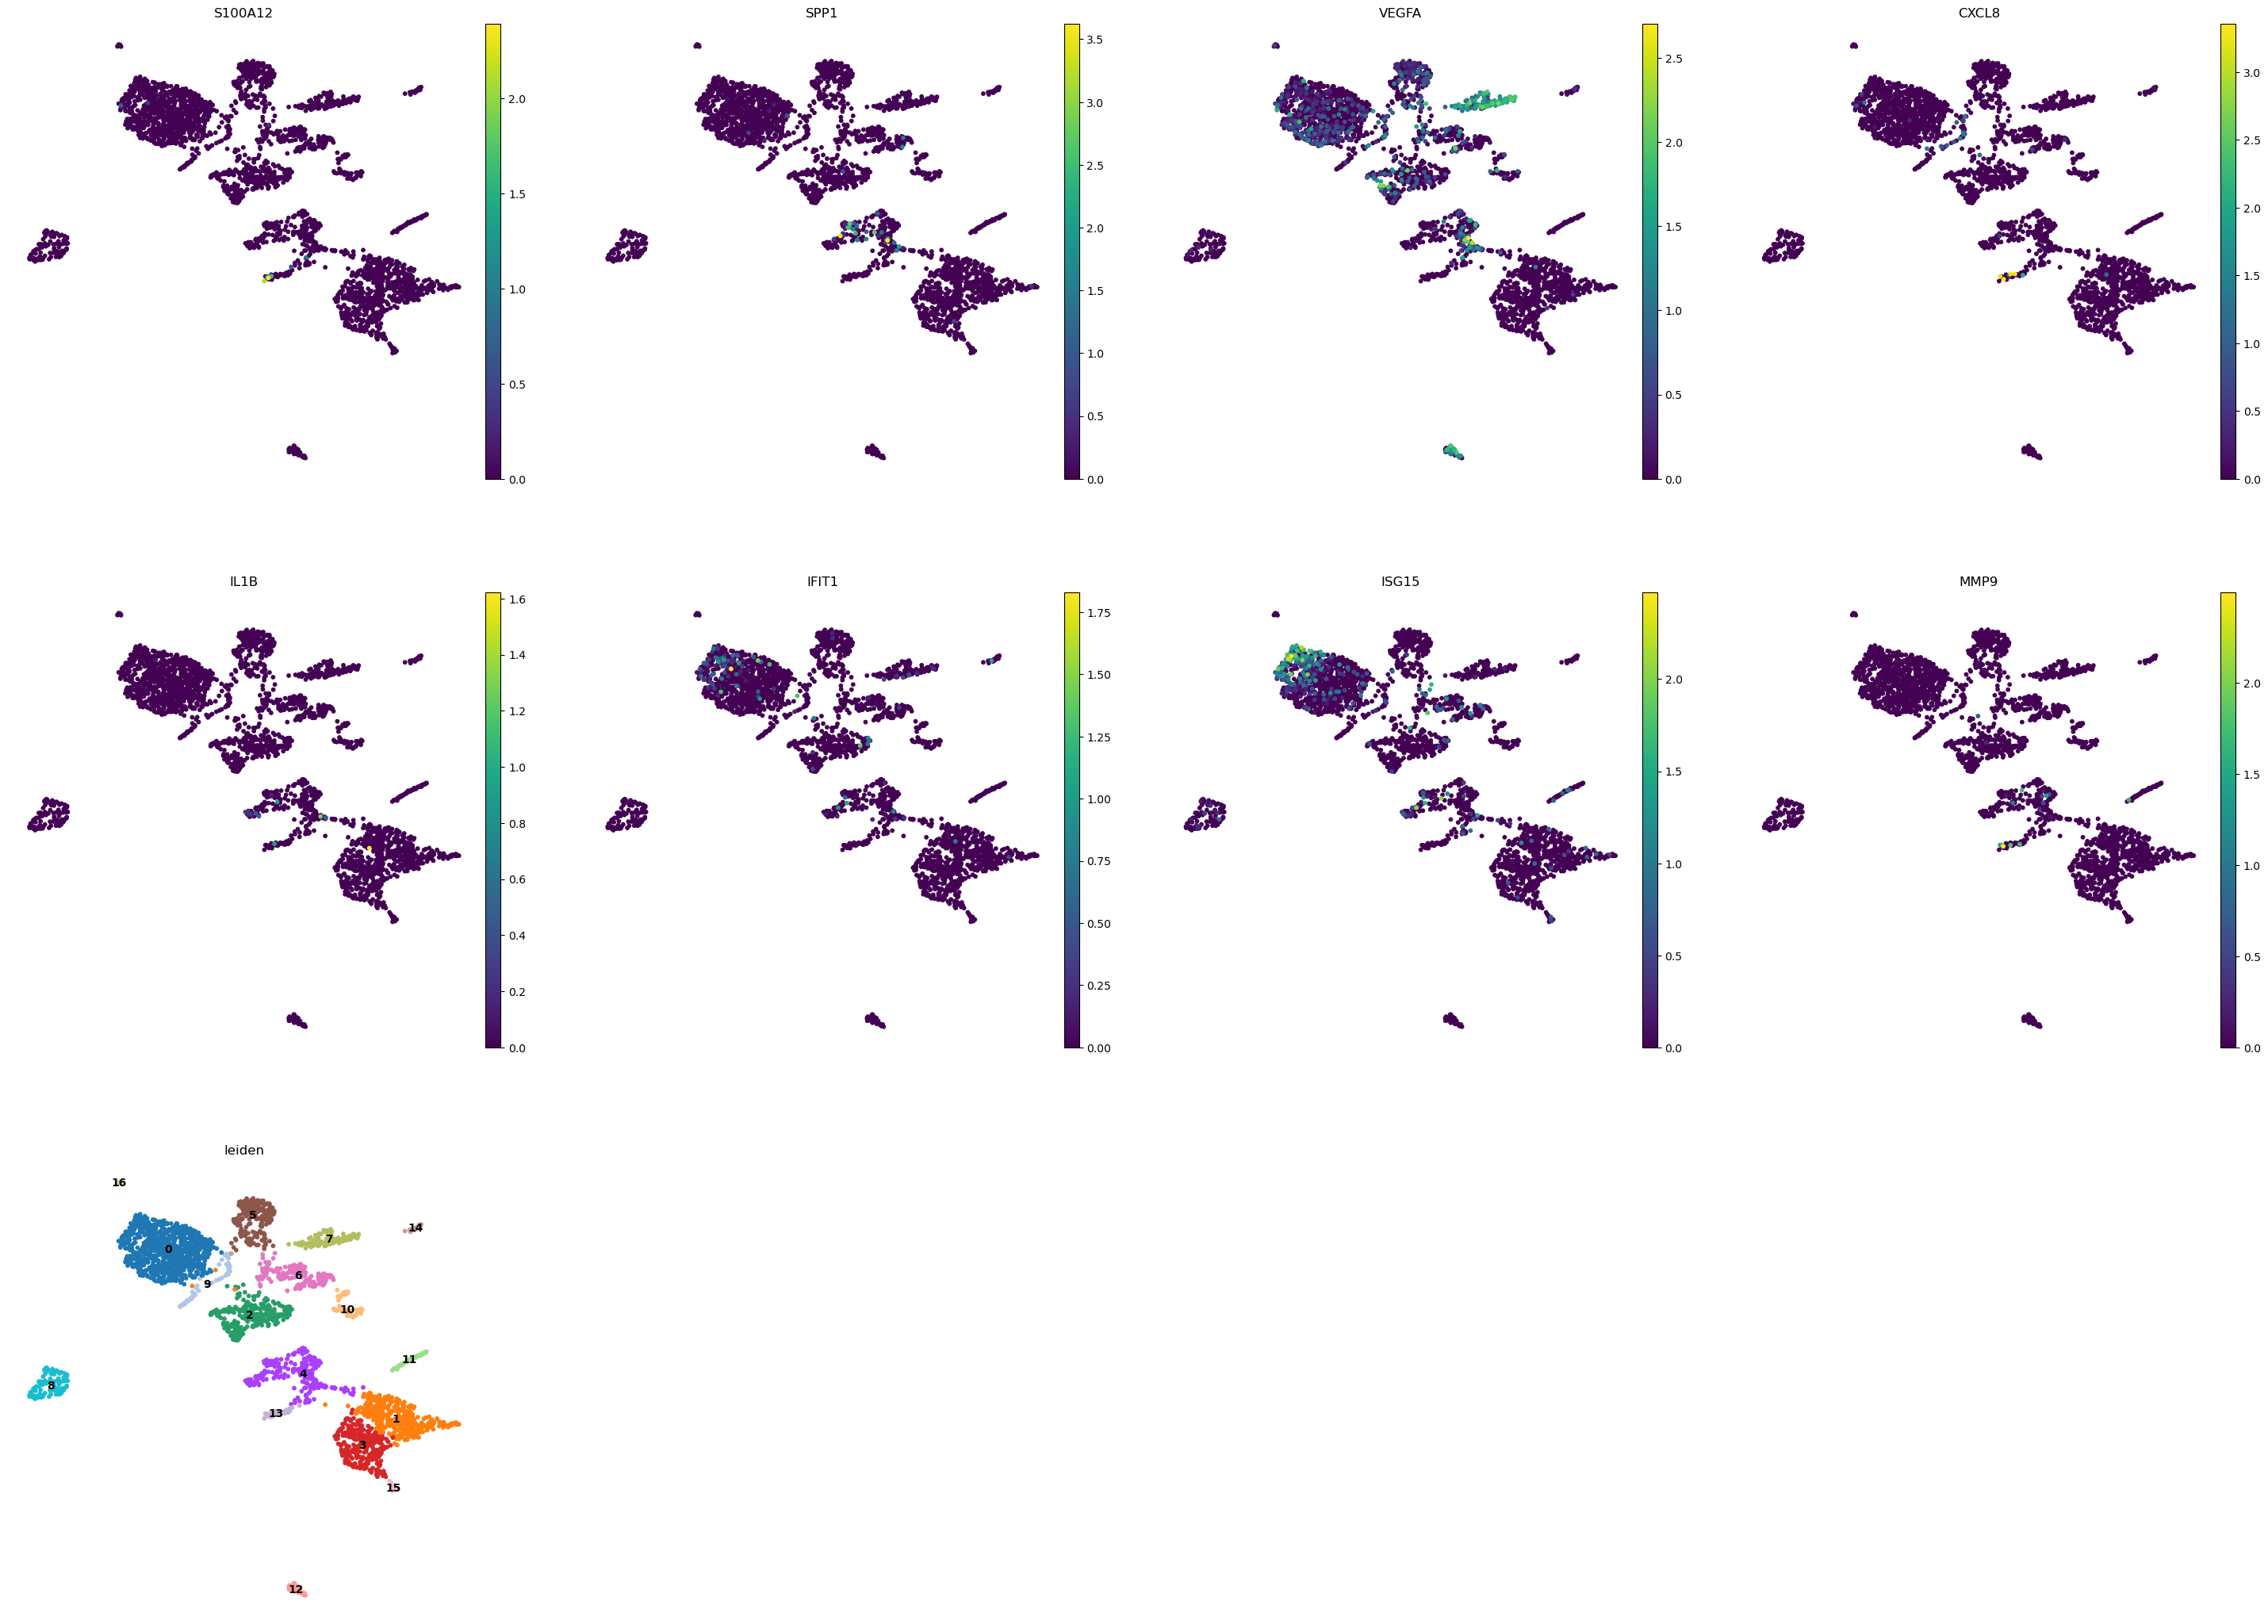

In [38]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_3, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1)

In [39]:
markers = {}
for c in adata_3.obs['leiden'].cat.categories:
    df = sc.get.rank_genes_groups_df(adata_3, group=c)
    markers[c] = df['names'].tolist()[:5]

In [40]:
markers

{'0': ['IFI6', 'IFI27', 'SCGB3A2', 'AZGP1', 'MDK'],
 '1': ['TRAC', 'ITK', 'TRBC2', 'SPOCK2', 'LCP1'],
 '2': ['DCN', 'COL1A2', 'COL6A3', 'A2M', 'MGP'],
 '3': ['CCL5', 'KLRK1', 'CD8A', 'TRAC', 'TRBC2'],
 '4': ['CTSB', 'CD163', 'C1QA', 'IFI30', 'TYROBP'],
 '5': ['SFTPA1', 'SFTPA2', 'SLPI', 'FASN', 'LRRK2'],
 '6': ['EPAS1', 'PECAM1', 'DEPP1', 'CLDN5', 'EGFL7'],
 '7': ['EMP2', 'AGER', 'CAV1', 'ADRB2', 'VEGFA'],
 '8': ['TXNDC5', 'DERL3', 'JCHAIN', 'MZB1', 'IGHA1'],
 '9': ['SLPI', 'CAPS', 'SLC44A4', 'TSPAN1', 'ODF3B'],
 '10': ['ACTA2', 'TAGLN', 'TPM2', 'COL6A2', 'COL4A2'],
 '11': ['MS4A1', 'IRF8', 'CD37', 'LAPTM5', 'CD79A'],
 '12': ['TPSB2', 'TPSAB1', 'KIT', 'CPA3', 'IL1RL1'],
 '13': ['S100A9', 'SLC11A1', 'S100A8', 'SPI1', 'HCLS1'],
 '14': ['KRT15', 'F3', 'DEPRECATED_ENSG00000128422', 'KRT17', 'KRT5'],
 '15': ['GNLY', 'KLRD1', 'NKG7', 'PRF1', 'ADGRG1'],
 '16': ['TBX1', 'CCL21', 'MMRN1', 'KALRN', 'LMO2']}

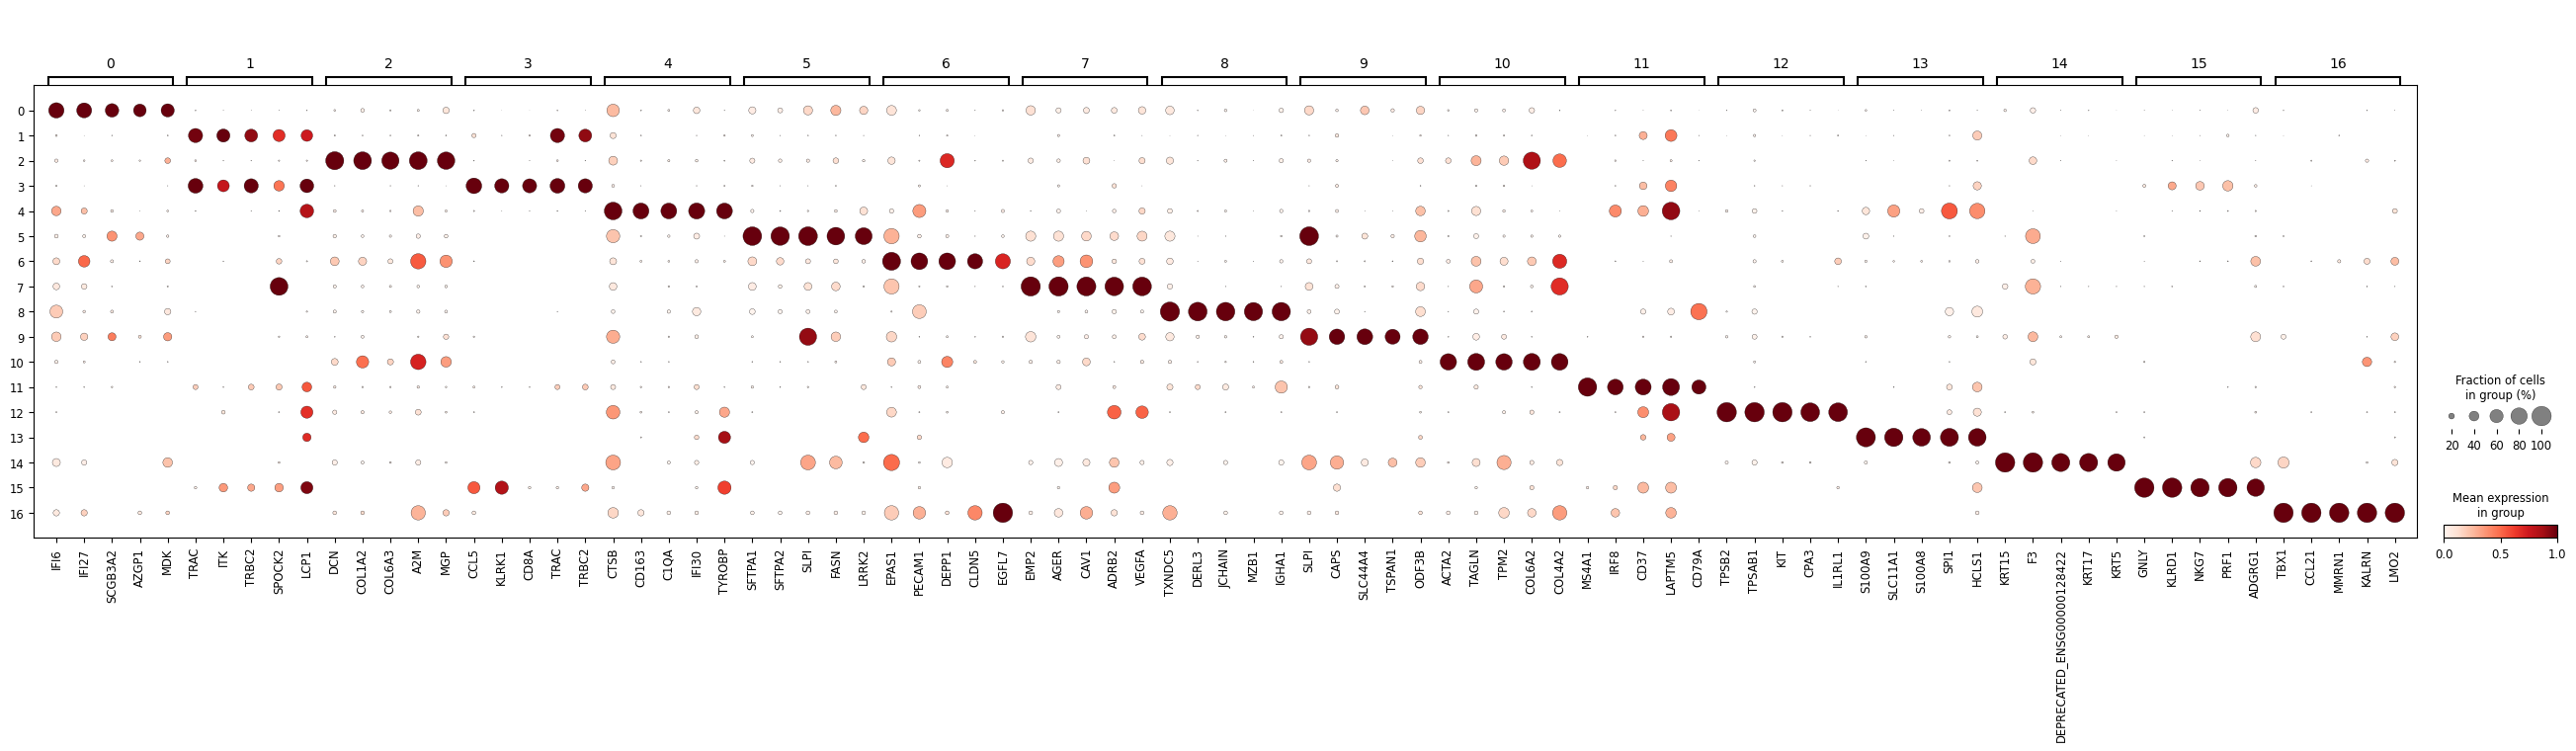

In [41]:
sc.pl.dotplot(adata_3, markers, groupby='leiden', use_raw=True, standard_scale='var')

In [42]:
subset_adata_3 = adata_3[adata_3.obs['leiden'].isin(['13','4','7','0']), :]

In [44]:
sc.pp.neighbors(subset_adata_3, n_pcs=41)
sc.tl.leiden(subset_adata_3, resolution = 0.5)
sc.tl.umap(subset_adata_3)
sc.write('subset_adata_3.h5ad', subset_adata_3)

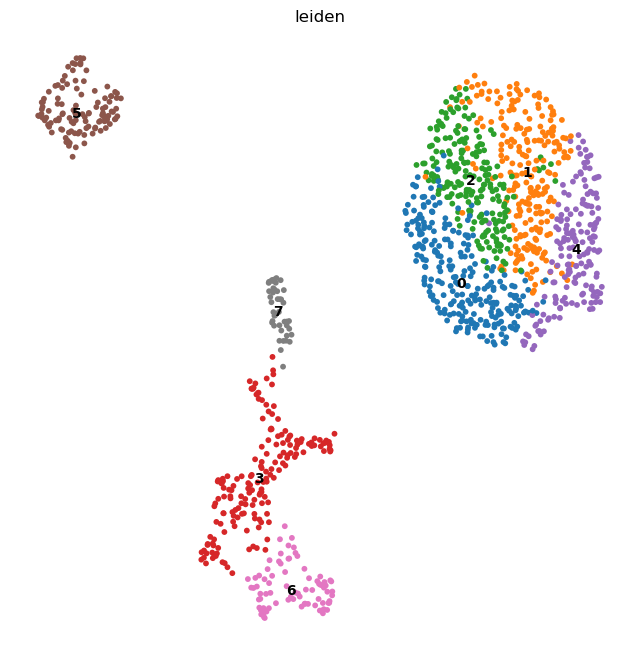

In [45]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_adata_3, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

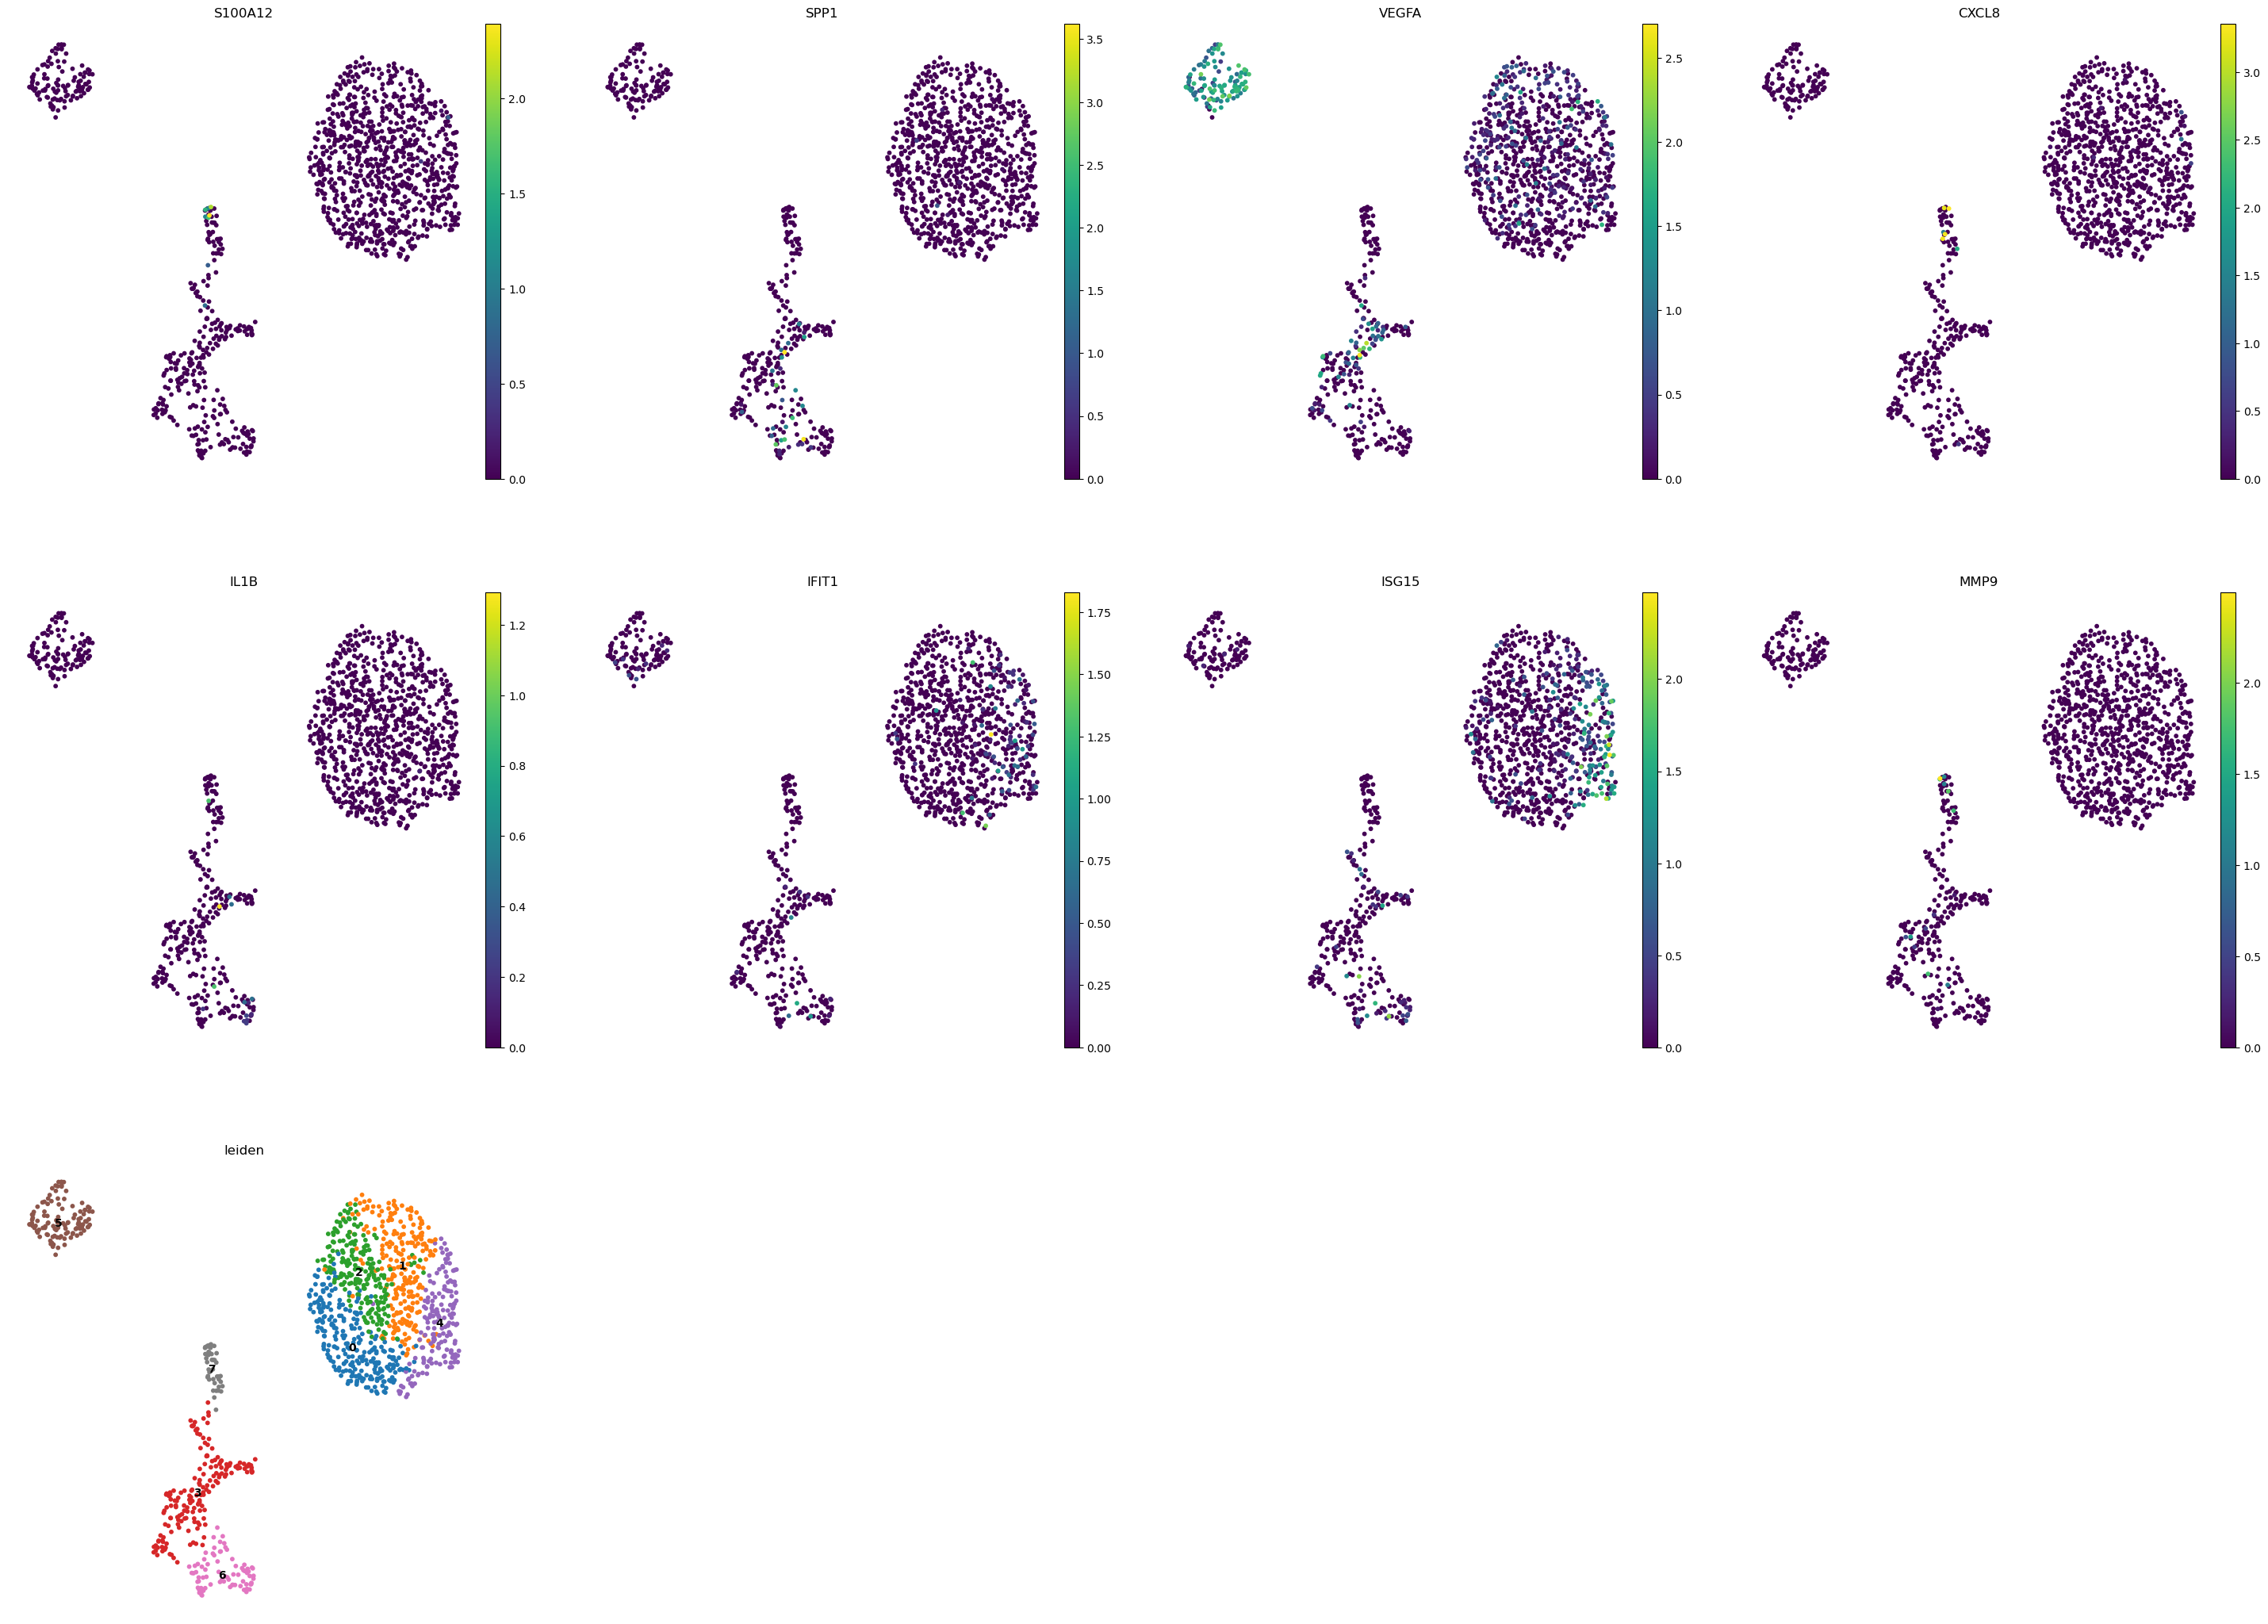

In [46]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_adata_3, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1)

In [ ]:
#SCVI for clustering

In [47]:
import scvi
def model(adata):
    adata.layers['Counts'] = adata.X.copy()
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = True, layer = 'Counts', flavor = "seurat_v3")
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable] 
    adata = adata.copy()
    scvi.model.SCVI.setup_anndata(adata, layer = "Counts", continuous_covariate_keys=['pct_counts_mt', 'total_counts'])
    vae = scvi.model.SCVI(adata)
    vae.train()
    vae.save(model_path)
    adata.obsm['X_scVI'] = vae.get_latent_representation()
    adata.layers["X_normalized_scVI"] = vae.get_normalized_expression()
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata)
    return adata

In [48]:
scvi_adata_3 = sc.read('adata_3_filtered_new.h5ad')

In [49]:
model_path = 'vae_model_3/'

In [50]:
scvi_adata_3 = model(scvi_adata_3)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|████████████████████| 400/400 [01:17<00:00,  4.92it/s, v_num=1, train_loss_step=411, train_loss_epoch=403]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████| 400/400 [01:17<00:00,  5.17it/s, v_num=1, train_loss_step=411, train_loss_epoch=403]


In [51]:
vae = scvi.model.SCVI.load(model_path, adata=scvi_adata_3)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File vae_model_3/model.pt already downloaded                                                              


In [52]:
scvi_adata_3

AnnData object with n_obs × n_vars = 3023 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'Counts', 'X_normalized_scVI'
    obsp: 'distances', 'connectivities'

In [53]:
sc.tl.leiden(scvi_adata_3, resolution = 0.5)
sc.write('adata_3_scvi_new.h5ad', scvi_adata_3)

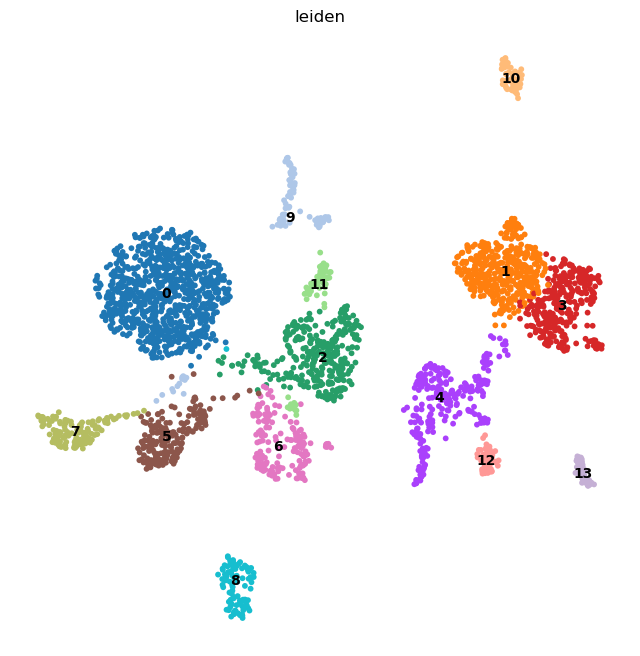

In [54]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_3, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

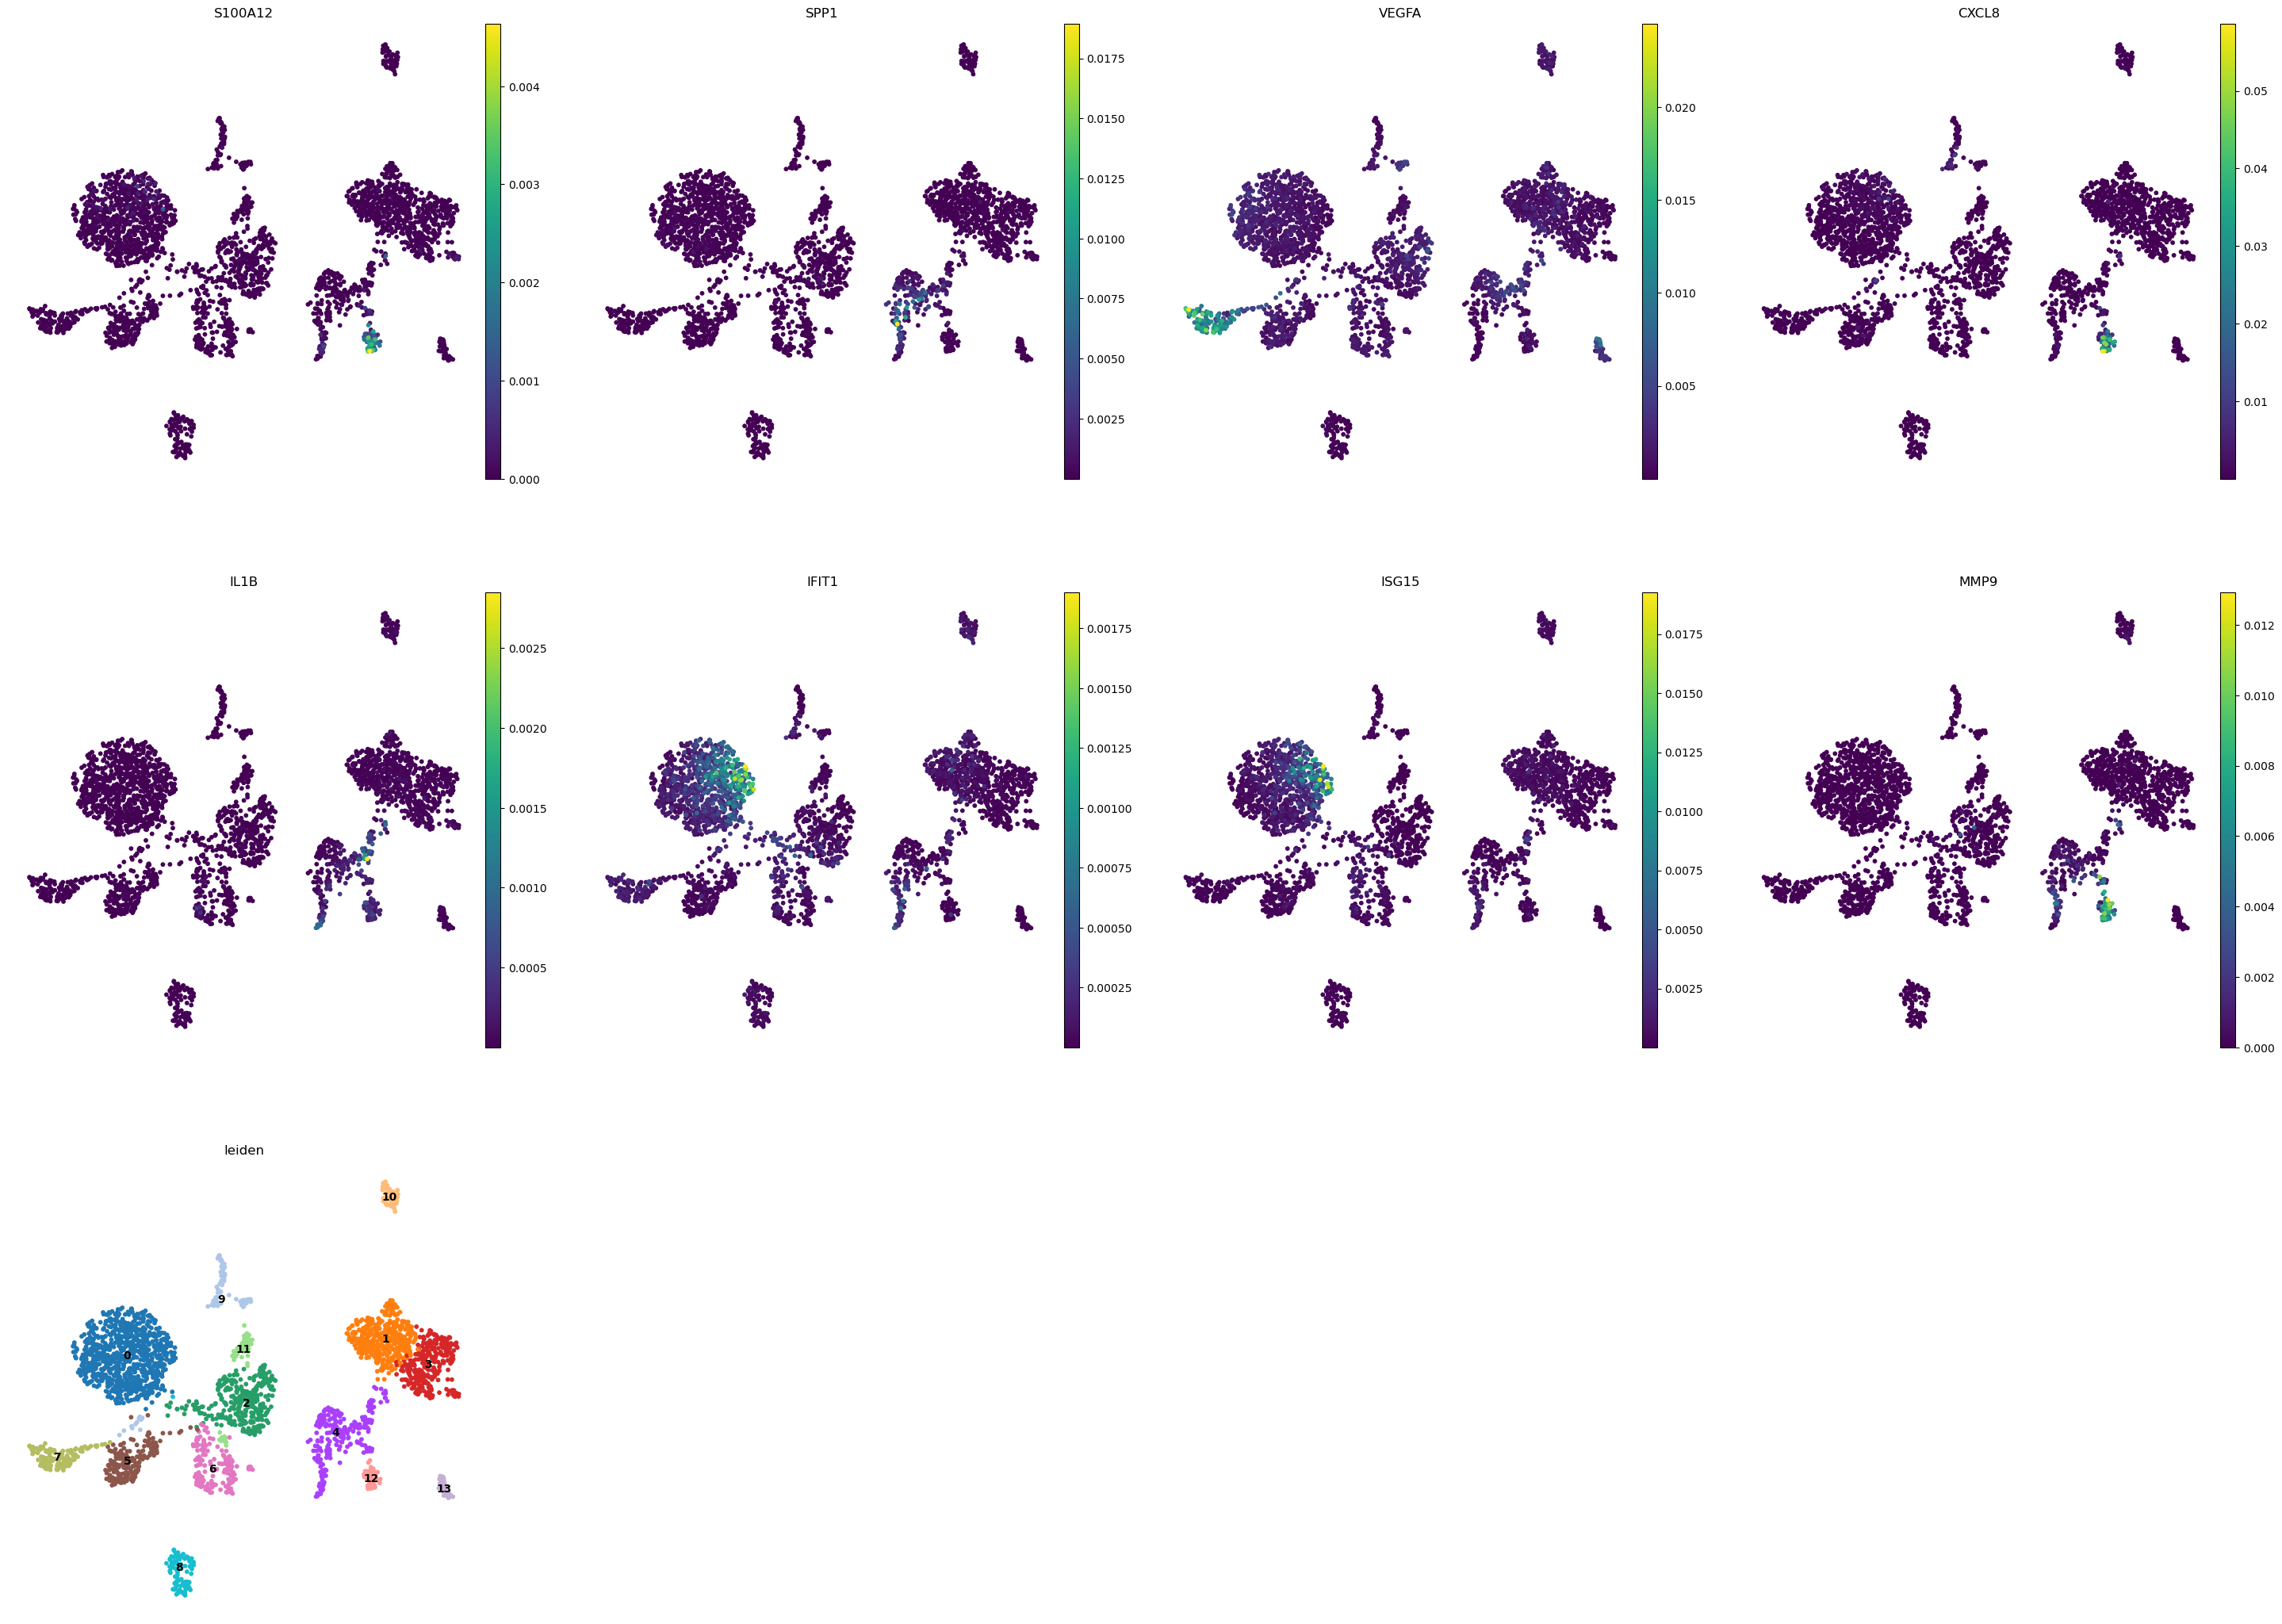

In [55]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(scvi_adata_3, color = n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=1, layer = "X_normalized_scVI")

In [56]:
scvi_df_3 = vae.differential_expression(groupby = 'leiden')

DE...: 100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.08it/s]


In [57]:
#scvi_df_3.to_csv('scvi_de_3_results.csv', index=False)

In [58]:
scvi_markers_3 = {}
for c in scvi_adata_3.obs.leiden.cat.categories:
    cell_df = scvi_df_3.loc[scvi_df_3.group1 == c]
    scvi_markers_3[c] = cell_df.index.tolist()[:5]

In [59]:
scvi_markers_3

{'0': ['MMP15', 'ETV4', 'HABP2', 'QPRT', 'CRABP2'],
 '1': ['CD8A', 'ADAM23', 'KLRK1', 'KLRD1', 'CCL5'],
 '2': ['LAMA2', 'COL6A3', 'PDGFRA', 'MMP2', 'PRELP'],
 '3': ['KLRC4', 'NKG7', 'KLRD1', 'CST7', 'KLRC3'],
 '4': ['NCF2', 'C1QC', 'CSF1R', 'MRC1', 'C1QB'],
 '5': ['SFTPA2', 'SFTPA1', 'FGG', 'HHIP', 'WIF1'],
 '6': ['PTPRB', 'CLEC14A', 'RAMP3', 'CLDN5', 'ROBO4'],
 '7': ['EMP2', 'SEMA3B', 'AGER', 'LAMA3', 'NCKAP5'],
 '8': ['S100A12', 'JCHAIN', 'IGLC2', 'IGLC3', 'IGHG2'],
 '9': ['CHST9', 'MUC4', 'IL2RA', 'CCL24', 'CCDC81'],
 '10': ['MS4A1', 'PAX5', 'NCAN', 'BLK', 'CD79A'],
 '11': ['ADCY5', 'NTRK3', 'ATP1A2', 'ACTA2', 'CALD1'],
 '12': ['AQP9', 'FCAR', 'S100A9', 'IL1R2', 'MMP25'],
 '13': ['CALB2', 'CMA1', 'CTSG', 'SIGLEC6', 'HPGDS']}

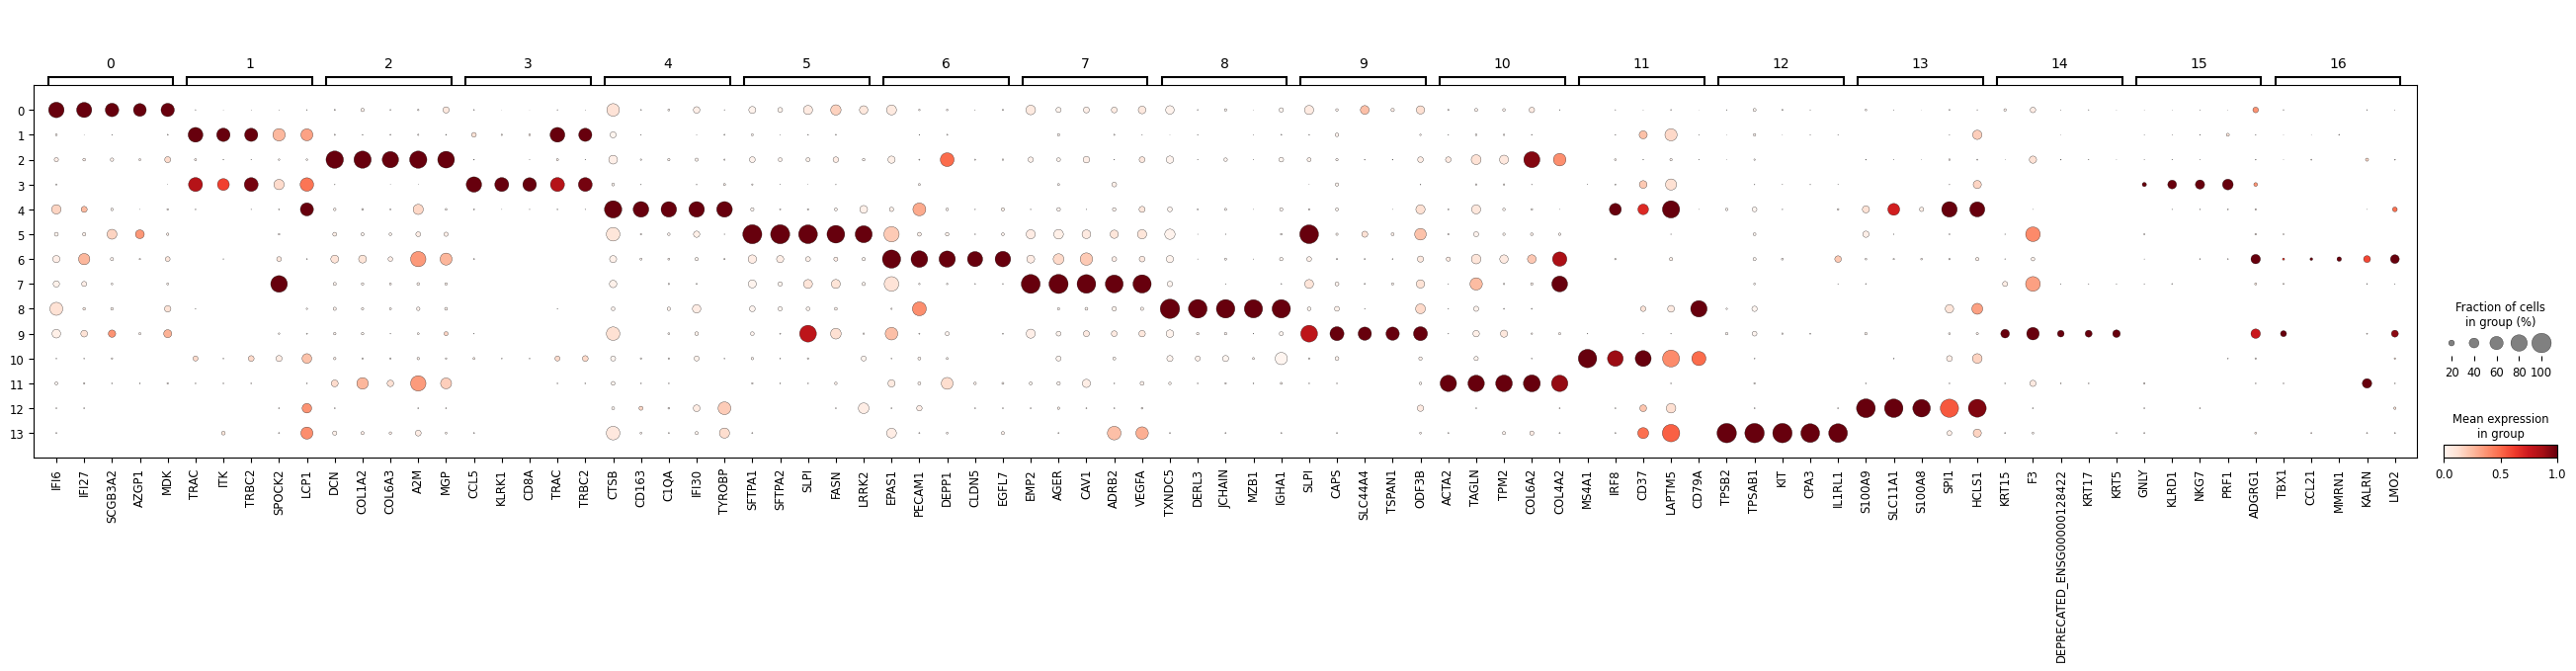

In [60]:
sc.pl.dotplot(scvi_adata_3, markers, groupby='leiden', use_raw=True, standard_scale='var')

In [61]:
subset_scvi_adata_3 = scvi_adata_3[adata_3.obs['leiden'].isin(['12','4','0','7']), :]

In [62]:
subset_scvi_adata_3

View of AnnData object with n_obs × n_vars = 1280 × 2000
    obs: 'n_genes', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'Counts', 'X_normalized_scVI'
    obsp: 'distances', 'connectivities'

In [67]:
sc.pp.neighbors(subset_scvi_adata_3, use_rep="X_scVI")
sc.tl.umap(subset_scvi_adata_3)

In [70]:
sc.tl.leiden(subset_scvi_adata_3, resolution = 0.5)

In [64]:
#sc.write('subset_scvi_adata_3.h5ad', subset_scvi_adata_3)

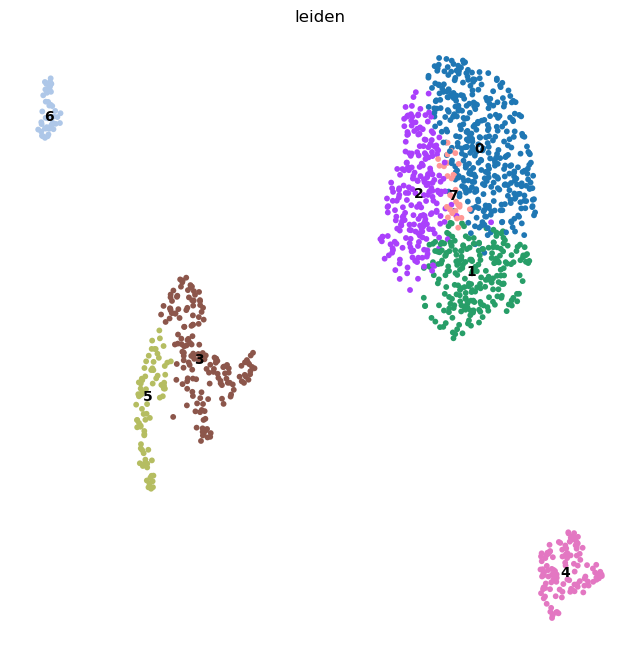

In [71]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_scvi_adata_3, color = 'leiden', s = 70, frameon=False, legend_loc="on data", alpha=1)

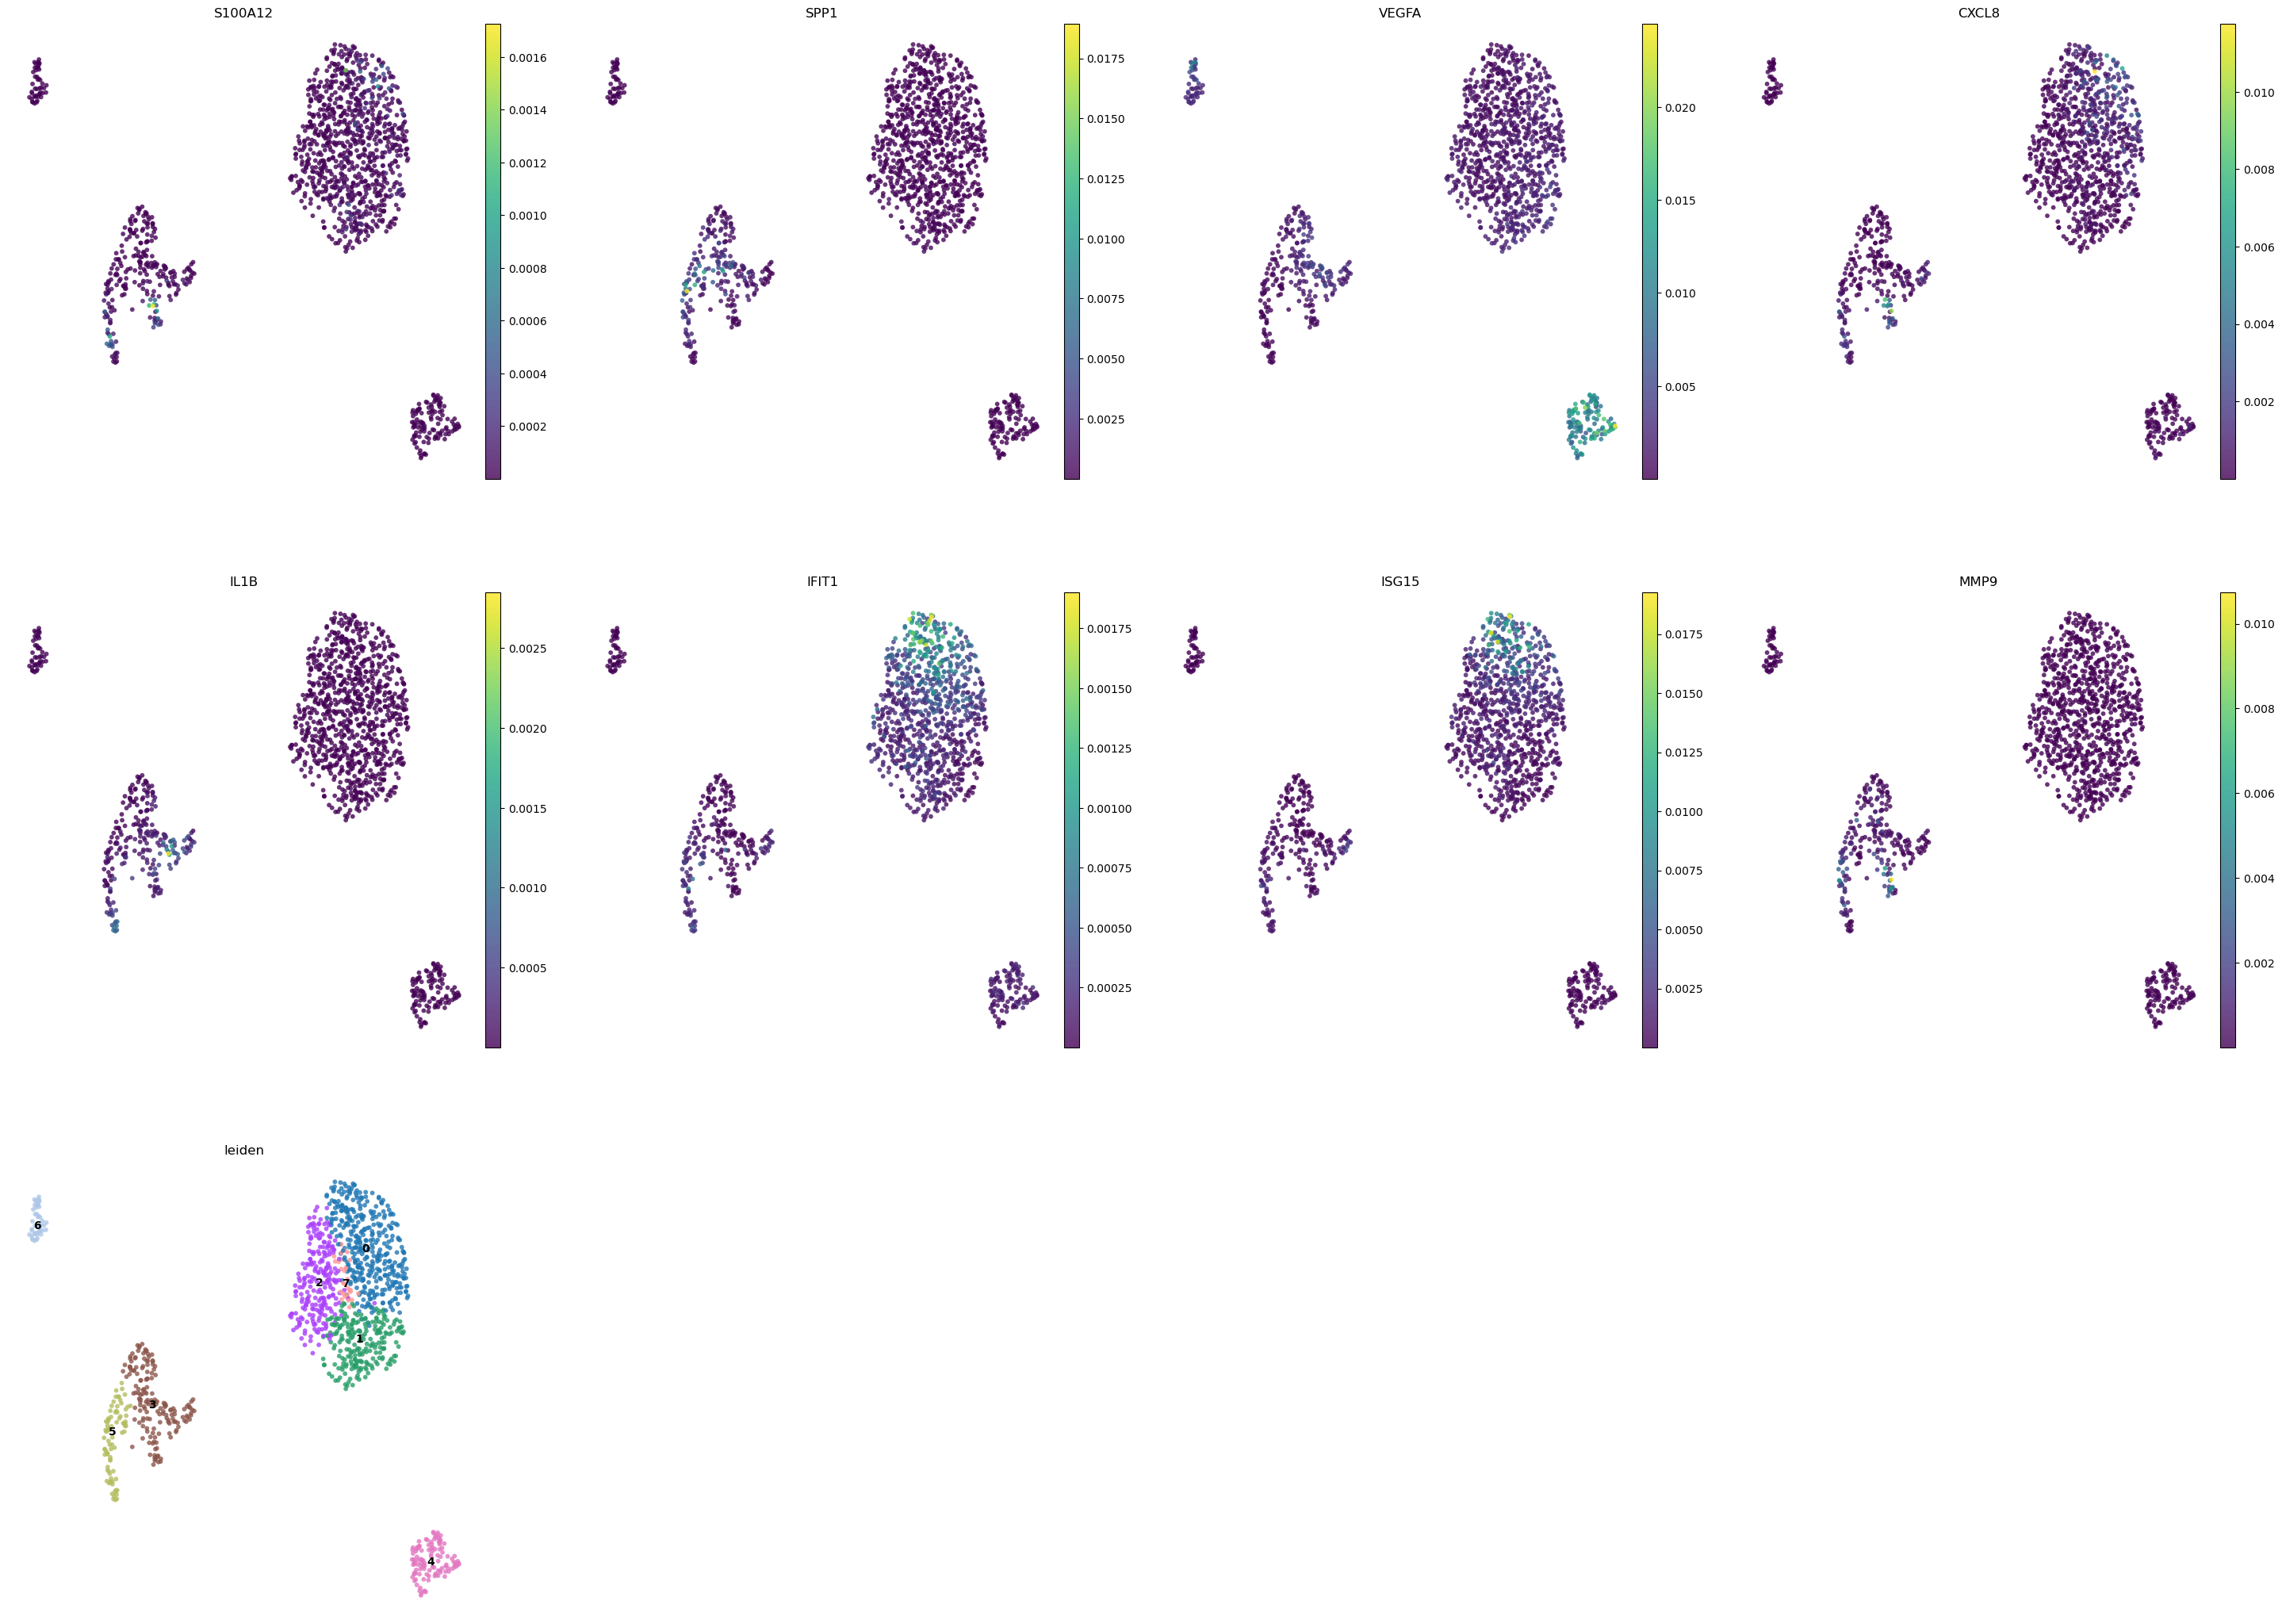

In [72]:
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(subset_scvi_adata_3, color=n_markers + ['leiden'], s = 70, frameon=False, legend_loc="on data", alpha=0.8, layer = "X_normalized_scVI")